# Applying the Variational Principle to Impacts: An Illustrative Example

We will be looking into a particle in gravity system that impacts the floor at some height.

## Imports and Helpers

In [ ]:
import numpy as np
import sympy as sym
from sympy.abc import t
%matplotlib inline
import matplotlib.pyplot as plt

#######################
# Custom latex printing
def custom_latex_printer(exp,**options):
    from google.colab.output._publish import javascript
    url = "https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.3/latest.js?config=TeX-AMS_HTML"
    javascript(url=url)
    return sym.printing.latex(exp,**options)
sym.init_printing(use_latex="mathjax",latex_printer=custom_latex_printer)

####################
# Simulation helpers
def integrate(f,x0,dt):
    """
    This function takes in an initial condition x0 and a timestep dt,
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. It outputs a vector x at the future time step.
    """
    k1=dt*f(x0)
    k2=dt*f(x0+k1/2.)
    k3=dt*f(x0+k2/2.)
    k4=dt*f(x0+k3)
    xnew=x0+(1/6.)*(k1+2.*k2+2.*k3+k4)
    return xnew

### Simulate impacts function starter code:
If you were to make a copy of this code and run it all, you would not be able to simulate impacts. You will need to change this function below in your homework in some way to account for impacts.

In [ ]:
################################
# TO BE CHANGED IN YOUR HOMEWORK
def simulate_impact(f,x0,tspan,dt,phi_condition,impact_update):
    """
    This function takes in an initial condition x0, a timestep dt,
    a time span tspan consisting of a list [min_time, max_time],
    as well as a dynamical system f(x) that outputs a vector of the
    same dimension as x0. Additionally, it takes in a function
    phi_condition(x) that evaluates whether or not a system is undergoing
    impacts. Finally, impact_update(x) is a function that applies the
    update law. simulate_impact outputs a full trajectory simulated
    over the time span of dimensions (xvec_size, time_vec_size).
    """
    N = int((max(tspan)-min(tspan))/dt)
    x = np.copy(x0)
    tvec = np.linspace(min(tspan),max(tspan),N)
    xtraj = np.zeros((len(x0),N))
    for i in range(N):
        xtraj[:,i]=integrate(f,x,dt)
        x = np.copy(xtraj[:,i])
    return xtraj

## Setting up variables and constants we expect to use

In [ ]:
# Problem variables and constants
m, g, h, lamb, tau, tau_minus, tau_plus = sym.symbols('m g h \lambda τ τ^- τ^+')
x = sym.Function(r'x')(t)
y = sym.Function(r'y')(t)
q = sym.Matrix([x, y])
qdot = q.diff(t)
qddot = qdot.diff(t)

## Putting together our Lagrangian

In [ ]:
# Getting Kinetic and Potential Energy
KE = sym.simplify(sym.Rational(1,2)*m*qdot.T.dot(qdot))
PE = m*g*(q[1])
Lag = KE-PE

print("Kinetic energy:")
display(KE)
print("Potential energy:")
display(PE)
print("Lagrangian:")
display(Lag)

Kinetic energy:


  ⎛          2             2⎞
  ⎜⎛d       ⎞    ⎛d       ⎞ ⎟
m⋅⎜⎜──(x(t))⎟  + ⎜──(y(t))⎟ ⎟
  ⎝⎝dt      ⎠    ⎝dt      ⎠ ⎠
─────────────────────────────
              2              

Potential energy:


g⋅m⋅y(t)

Lagrangian:


              ⎛          2             2⎞
              ⎜⎛d       ⎞    ⎛d       ⎞ ⎟
            m⋅⎜⎜──(x(t))⎟  + ⎜──(y(t))⎟ ⎟
              ⎝⎝dt      ⎠    ⎝dt      ⎠ ⎠
-g⋅m⋅y(t) + ─────────────────────────────
                          2              

## Solving Euler-Lagrange equations (no impacts yet...)

In [ ]:
dLdq = sym.simplify(sym.Matrix([Lag]).jacobian(q).T)
dLdqdot = sym.simplify(sym.Matrix([Lag]).jacobian(qdot).T)
ddLdqdot_dt = sym.simplify(dLdqdot.diff(t))
EL = sym.Eq(ddLdqdot_dt-dLdq,sym.Matrix([0,0]))
ELsols = sym.solve(EL,[qddot[0],qddot[1]])

print("Equations of motion:")
display(sym.Eq(qddot[0],ELsols[qddot[0]]))
display(sym.Eq(qddot[1],ELsols[qddot[1]]))

print("Converting dynamics to 1st order form:")
dyn = sym.Matrix([qdot[0],ELsols[qddot[0]],qdot[1],ELsols[qddot[1]]])
display(dyn)

Equations of motion:


  2          
 d           
───(x(t)) = 0
  2          
dt           

  2           
 d            
───(y(t)) = -g
  2           
dt            

Converting dynamics to 1st order form:


⎡d       ⎤
⎢──(x(t))⎥
⎢dt      ⎥
⎢        ⎥
⎢   0    ⎥
⎢        ⎥
⎢d       ⎥
⎢──(y(t))⎥
⎢dt      ⎥
⎢        ⎥
⎣   -g   ⎦

## Getting our Hamiltonian

In [ ]:
Ham = sym.simplify(dLdqdot.T.dot(qdot)-Lag)
print("Hamiltonian:")
display(Ham)

Hamiltonian:


  ⎛                     2             2⎞
  ⎜           ⎛d       ⎞    ⎛d       ⎞ ⎟
m⋅⎜2⋅g⋅y(t) + ⎜──(x(t))⎟  + ⎜──(y(t))⎟ ⎟
  ⎝           ⎝dt      ⎠    ⎝dt      ⎠ ⎠
────────────────────────────────────────
                   2                    

## Getting our impact surface (and its gradients)
Our impact surface for this problem is
$$
\phi(x,y) = y-h.
$$
This means that when $y=h$ we should hit the floor and bounce up.

In [ ]:
phi = q[1]-h
gradphi = sym.simplify(sym.Matrix([phi]).jacobian(q).T)
print("Gradient of our surface along q:")
display(gradphi)

Gradient of our surface along q:


⎡0⎤
⎢ ⎥
⎣1⎦

## Deriving the impact update equations

Let's get started with deriving the impact update and put together useful configuration variables:

In [ ]:
# Configuration variables before and after impact
q_tau = q.subs(t,tau)
q_minus = q.subs(t,tau_minus)
q_plus = q.subs(t,tau_plus)
qdot_minus = qdot.subs({q[0]:q_minus[0],q[1]:q_minus[1]})
qdot_plus = qdot.subs({q[0]:q_plus[0],q[1]:q_plus[1]})

### Momentum equations

In [ ]:
# Momentum before and after impact
p_minus = dLdqdot.subs({q[0]:q_minus[0],q[1]:q_minus[1],qdot[0]:qdot_minus[0],qdot[1]:qdot_minus[1]})
p_plus = dLdqdot.subs({q[0]:q_plus[0],q[1]:q_plus[1],qdot[0]:qdot_plus[0],qdot[1]:qdot_plus[1]})
p_eq = sym.Eq(sym.simplify(p_plus-p_minus),lamb*gradphi)

print("Impact equations due to momentum terms:")
display(p_eq)

Impact equations due to momentum terms:


⎡  ⎛d           d        ⎞⎤            
⎢m⋅⎜──(x(τ⁺)) - ──(x(τ⁻))⎟⎥            
⎢  ⎝dt          dt       ⎠⎥   ⎡   0   ⎤
⎢                         ⎥ = ⎢       ⎥
⎢  ⎛d           d        ⎞⎥   ⎣\lambda⎦
⎢m⋅⎜──(y(τ⁺)) - ──(y(τ⁻))⎟⎥            
⎣  ⎝dt          dt       ⎠⎦            

### Now let's see what we get for the Hamiltonian conservation equation:

In [ ]:
# Hamiltonian before and after impact
Ham_minus = Ham.subs({q[0]:q_minus[0],q[1]:q_minus[1],qdot[0]:qdot_minus[0],qdot[1]:qdot_minus[1]})
Ham_plus = Ham.subs({q[0]:q_plus[0],q[1]:q_plus[1],qdot[0]:qdot_plus[0],qdot[1]:qdot_plus[1]})
display(sym.Eq(sym.simplify(Ham_plus-Ham_minus),0))

  ⎛                                   2              2              2         
  ⎜                        ⎛d        ⎞    ⎛d        ⎞    ⎛d        ⎞    ⎛d    
m⋅⎜2⋅g⋅y(τ⁺) - 2⋅g⋅y(τ⁻) + ⎜──(x(τ⁺))⎟  - ⎜──(x(τ⁻))⎟  + ⎜──(y(τ⁺))⎟  - ⎜──(y(
  ⎝                        ⎝dt       ⎠    ⎝dt       ⎠    ⎝dt       ⎠    ⎝dt   
──────────────────────────────────────────────────────────────────────────────
                                          2                                   

     2⎞    
    ⎞ ⎟    
τ⁻))⎟ ⎟    
    ⎠ ⎠    
─────── = 0
           

### Is that right? Not quite! Don't forget that we only have a discontinuity in our velocities.

This is to say, $y(\tau^+)=y(\tau^-).$ So our Hamiltonian impact update equation is then:

In [ ]:
Ham_minus_actual = Ham.subs({qdot[0]:qdot_minus[0],qdot[1]:qdot_minus[1]})
Ham_plus_actual = Ham.subs({qdot[0]:qdot_plus[0],qdot[1]:qdot_plus[1]})
Ham_eq = sym.Eq(sym.simplify(Ham_plus_actual-Ham_minus_actual),0)

print("Impact equation due to Hamiltonian term:")
display(Ham_eq)

Impact equation due to Hamiltonian term:


  ⎛           2              2              2              2⎞    
  ⎜⎛d        ⎞    ⎛d        ⎞    ⎛d        ⎞    ⎛d        ⎞ ⎟    
m⋅⎜⎜──(x(τ⁺))⎟  - ⎜──(x(τ⁻))⎟  + ⎜──(y(τ⁺))⎟  - ⎜──(y(τ⁻))⎟ ⎟    
  ⎝⎝dt       ⎠    ⎝dt       ⎠    ⎝dt       ⎠    ⎝dt       ⎠ ⎠    
───────────────────────────────────────────────────────────── = 0
                              2                                  

### We can solve for the update directly from the equation above

In [ ]:
ImpactEqs = sym.Eq(sym.Matrix([Ham_eq.lhs,p_eq.lhs[0],p_eq.lhs[1]]),sym.Matrix([Ham_eq.rhs,p_eq.rhs[0],p_eq.rhs[1]]))
ImpactSols = sym.solve(ImpactEqs,[qdot_plus[0],qdot_plus[1],lamb])

print("Solution 1:")
sol1 = sym.Matrix([ImpactSols[0][0],ImpactSols[0][1],ImpactSols[0][2]])
display(sym.Eq(sym.Matrix([qdot_plus[0],qdot_plus[1],lamb]),sol1))

print("Solution 2:")
sol2 = sym.Matrix([ImpactSols[1][0],ImpactSols[1][1],ImpactSols[1][2]])
display(sym.Eq(sym.Matrix([qdot_plus[0],qdot_plus[1],lamb]),sol2))

Solution 1:


              ⎡  d           ⎤
⎡d        ⎤   ⎢  ──(x(τ⁻))   ⎥
⎢──(x(τ⁺))⎥   ⎢  dt          ⎥
⎢dt       ⎥   ⎢              ⎥
⎢         ⎥   ⎢   d          ⎥
⎢d        ⎥ = ⎢  -──(y(τ⁻))  ⎥
⎢──(y(τ⁺))⎥   ⎢   dt         ⎥
⎢dt       ⎥   ⎢              ⎥
⎢         ⎥   ⎢     d        ⎥
⎣ \lambda ⎦   ⎢-2⋅m⋅──(y(τ⁻))⎥
              ⎣     dt       ⎦

Solution 2:


⎡d        ⎤   ⎡d        ⎤
⎢──(x(τ⁺))⎥   ⎢──(x(τ⁻))⎥
⎢dt       ⎥   ⎢dt       ⎥
⎢         ⎥   ⎢         ⎥
⎢d        ⎥ = ⎢d        ⎥
⎢──(y(τ⁺))⎥   ⎢──(y(τ⁻))⎥
⎢dt       ⎥   ⎢dt       ⎥
⎢         ⎥   ⎢         ⎥
⎣ \lambda ⎦   ⎣    0    ⎦

This results in us getting a pair of solutions, but only one of them corresponds to physical behavior. Since $q$ must exist in the domain where $\phi(q)\geq0$, we can rule out the second solution, which implies that there is no impact surface.

In [ ]:
print("So our impact update boils down to:")
display(sym.Eq(qdot_plus[1],sol1[1]))

So our impact update boils down to:


d            d        
──(y(τ⁺)) = -──(y(τ⁻))
dt           dt       

## Preparing for numerical simulation

### Lambdifying our dynamics

In [ ]:
# We need dummy variables to avoid errors with the d/dt term
vx, vy = sym.symbols('v_x v_y')

# Substitute dummmy variable into both dynamics expressions
dyn_dummy = dyn.subs({qdot[0]:vx, qdot[1]:vy, g:9.81, m:1.0})

# Lambdify
lam_dyn = sym.lambdify([q[0],vx,q[1],vy],dyn_dummy)

# Define dynamics function
def dynamics(x):
    """
    the input 'x' contains x, xdot, y, ydot.
    the output 'xvec' is determined  by your dynamics.
    """
    xdot = lam_dyn(x[0],x[1],x[2],x[3])
    return np.squeeze(xdot)

### Lambdifying impact surface expression

In [ ]:
lam_phi = sym.lambdify([q[1]],phi.subs(h,0.0))

# Check phi(q)
def phi_condition(x):
    return lam_phi(x[2]) < 0

# Flip y velocity
def impact_update(x):
    newx = np.copy(x)
    newx[3] = -newx[3]
    return newx

### Let's get our Hamiltonian too for fun

In [ ]:
lam_Ham = sym.lambdify([q[0],vx,q[1],vy],Ham.subs({qdot[0]:vx, qdot[1]:vy, g:9.81, m:1.0}))

## Numerical simulation

In order to handle impacts, we will have to use our impact simulation function:

In [ ]:
tspan = [0,5]
dt = 0.01
x0 = np.array([0,0,1,0])
xvec = simulate_impact(dynamics,x0,tspan,dt,phi_condition,impact_update)
Hvec = np.array([lam_Ham(x[0],x[1],x[2],x[3]) for x in xvec.T])

## Plots

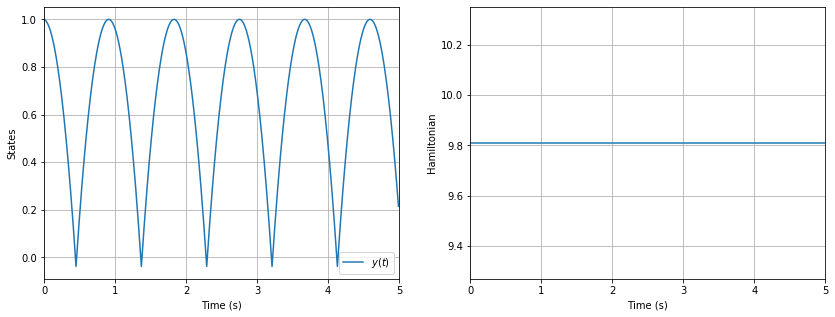

In [ ]:
t = np.arange(tspan[0],tspan[1],dt)
plt.figure(facecolor='w',figsize=(14,5))
plt.subplot(121)
plt.plot(t,xvec[2])
plt.grid(True)
plt.xlim(tspan)
plt.xlabel('Time (s)')
plt.ylabel('States')
plt.legend([r'$y(t)$'])

plt.subplot(122)
plt.plot(t,Hvec)
plt.grid(True)
plt.xlim(tspan)
plt.xlabel('Time (s)')
plt.ylabel('Hamiltonian')
plt.show()